# Bayesian A/B Testing

## Conversion Testing

Suppose we have two designs for a web page and we would like to know which web page will lead to more users signing up. Let us call these two web pages A and B. Suppose also that we have deployed these two web pages and have data on how many people have signed up with each site, we call this conversions. 

In [2]:
visitors_to_A = 1200
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125

## Suppose we have a Beta Prior

We will determine which site is better by comparing posterior for each site. To determine the posterior, we will guess the prior. Let us assume that we have a Beta Prior. Beta distribution is reasonable because the values are restricted between 0 and 1, which is the range for sign up pages for our users. If prior is Beta($\alpha_0$, $\beta_0$) and we observe N trials and X successes, then posterior is Beta($\alpha_0$ + $X$, $\beta_0$ + $N - X$) 

In [3]:
from scipy.stats import beta

In [4]:
alpha_prior = 1
beta_prior = 1

posterior_A = beta(alpha_prior + conversions_from_A, 
                  beta_prior + visitors_to_A - conversions_from_A)

posterior_B = beta(alpha_prior + conversions_from_B, 
                  beta_prior + visitors_to_B - conversions_from_B)



In [5]:
samples = 20000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)


print((samples_posterior_A > samples_posterior_B).mean())

0.56225


We see the mean of samples_posterior_A greater than samples_posterior_B is 0.5628 which means that the probability that web page A is better than web page B at retaining signups is 56.28%. We can decide based off of this percentage whether or not this is enough evidence for us to choose one web page or not. 

In [6]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import numpy as np

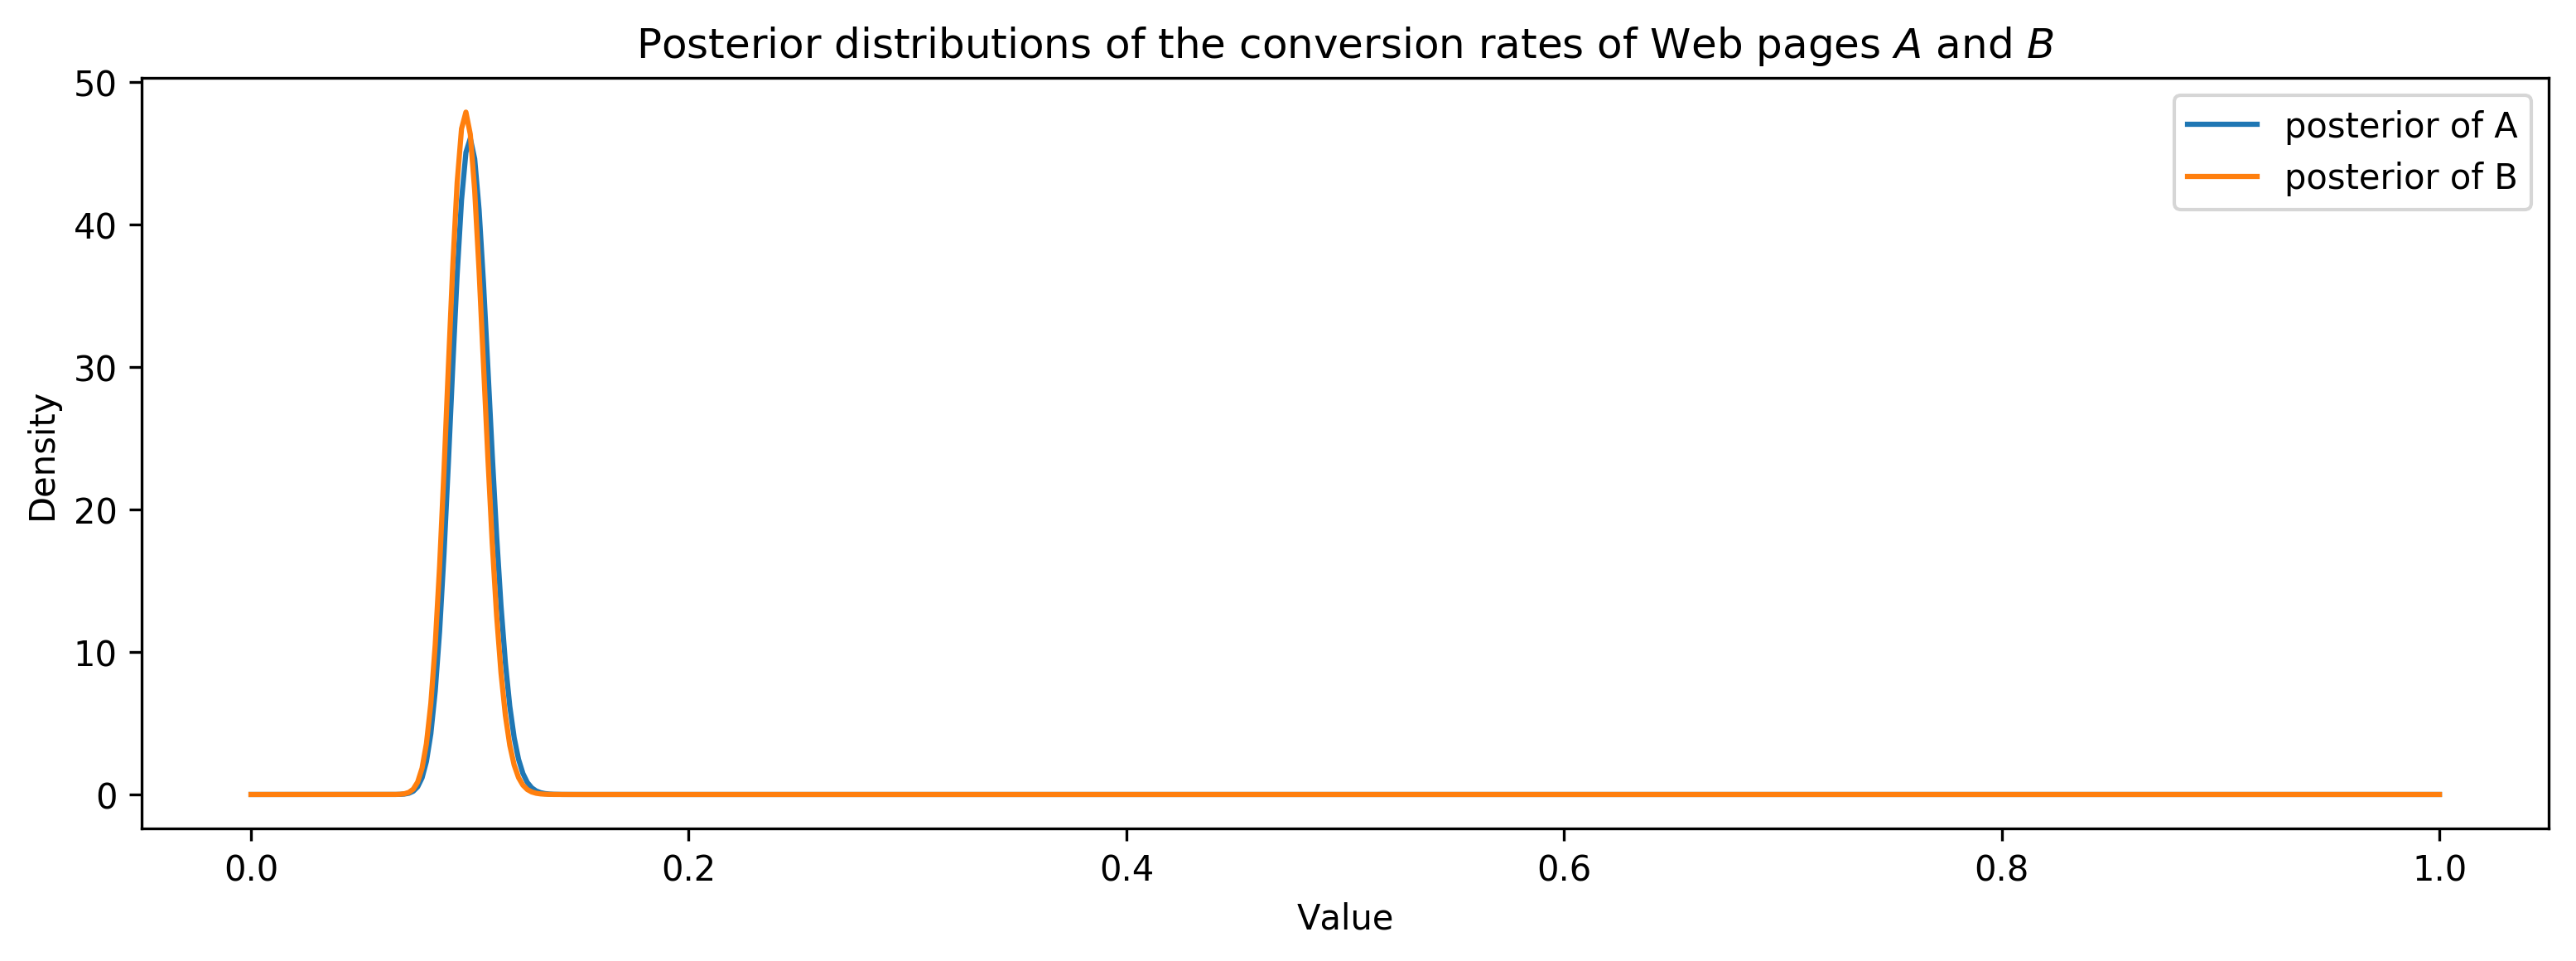

In [7]:
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
x = np.linspace(0, 1, 500)
plt.plot(x, posterior_A.pdf(x), label='posterior of A')
plt.plot(x, posterior_B.pdf(x), label='posterior of B')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the conversion rates of Web pages $A$ and $B$")

plt.legend();

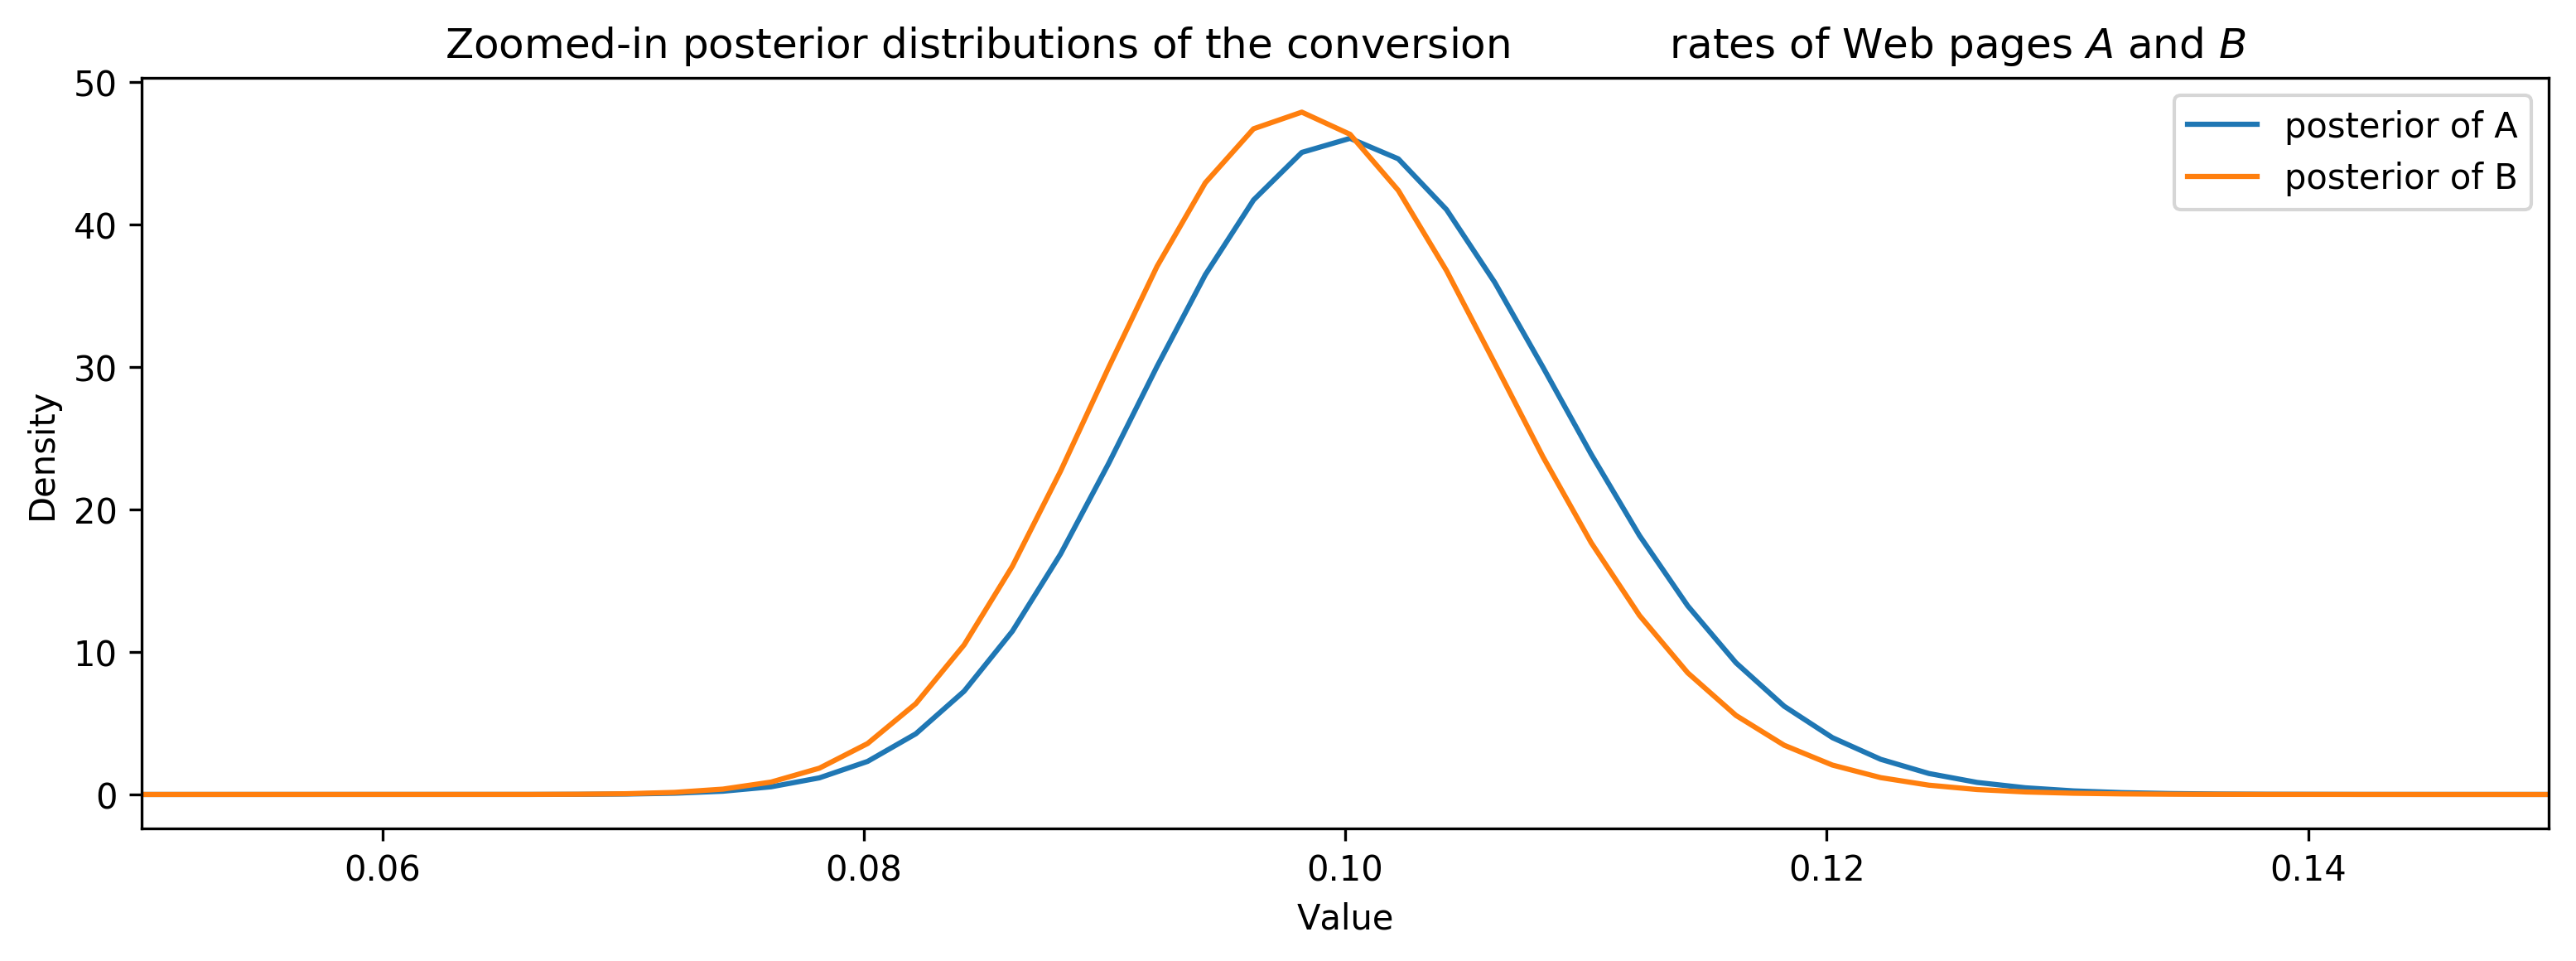

In [8]:
plt.plot(x, posterior_A.pdf(x), label='posterior of A')
plt.plot(x, posterior_B.pdf(x), label='posterior of B')
plt.xlim(0.05, 0.15)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Zoomed-in posterior distributions of the conversion\
            rates of Web pages $A$ and $B$")
plt.legend();

## Expected Revenue Analysis

We have just illustrated how to find out which web page is better at getting new users to sign up. But suppose we would like to know which package would yield a better profit. We will now go through the necessary steps to figure this out. 

We assume that the profit model can be determined with $E[R] = 79p_{79} + 49p_{49} + 25p_{25} + 0p_{0}$. N_79, N_49, N_25, N_0 are purchases/ subscription packages that users can buy. N_79 costs the user 79 dollars, N_49 costs the user 49 dollars, and so on and so forth. N_0 costs $0 and this represents the number of users that do not buy any of our products. 

Since the probabilities of each of these events (purchase packages) are correlated, we cannot choose beta/binomial model as prior like before The conjugate is a dirichlet, so that is why we choose the dirichlet as our posterior. 

We assume that prior is Dirichlet([1, 1, 1, 1]). Thus, the posterior is Dirichlet([1 + $N_1, 1 + N_2, 1 + N_3 + 1 + N_4$]), where $N_1, N_2, N_3$, and $N_4$ are our observations. 

In [9]:
from numpy.random import dirichlet 
N = 1000
N_79 = 10
N_49 = 46
N_25 = 80
N_0 = N - (N_79 + N_49 + N_25)

observations = np.array([N_79, N_49, N_25, N_0])

prior_parameters = np.array([1, 1, 1, 1])
posterior_samples = dirichlet(prior_parameters + observations, size=10000)

print("Two random samples from the posterior: ")
print(posterior_samples[0])
print(posterior_samples[1])

Two random samples from the posterior: 
[ 0.01040189  0.0476649   0.08050148  0.86143173]
[ 0.0136431   0.06222916  0.07074218  0.85338556]


## We plot probability density function of this posterior

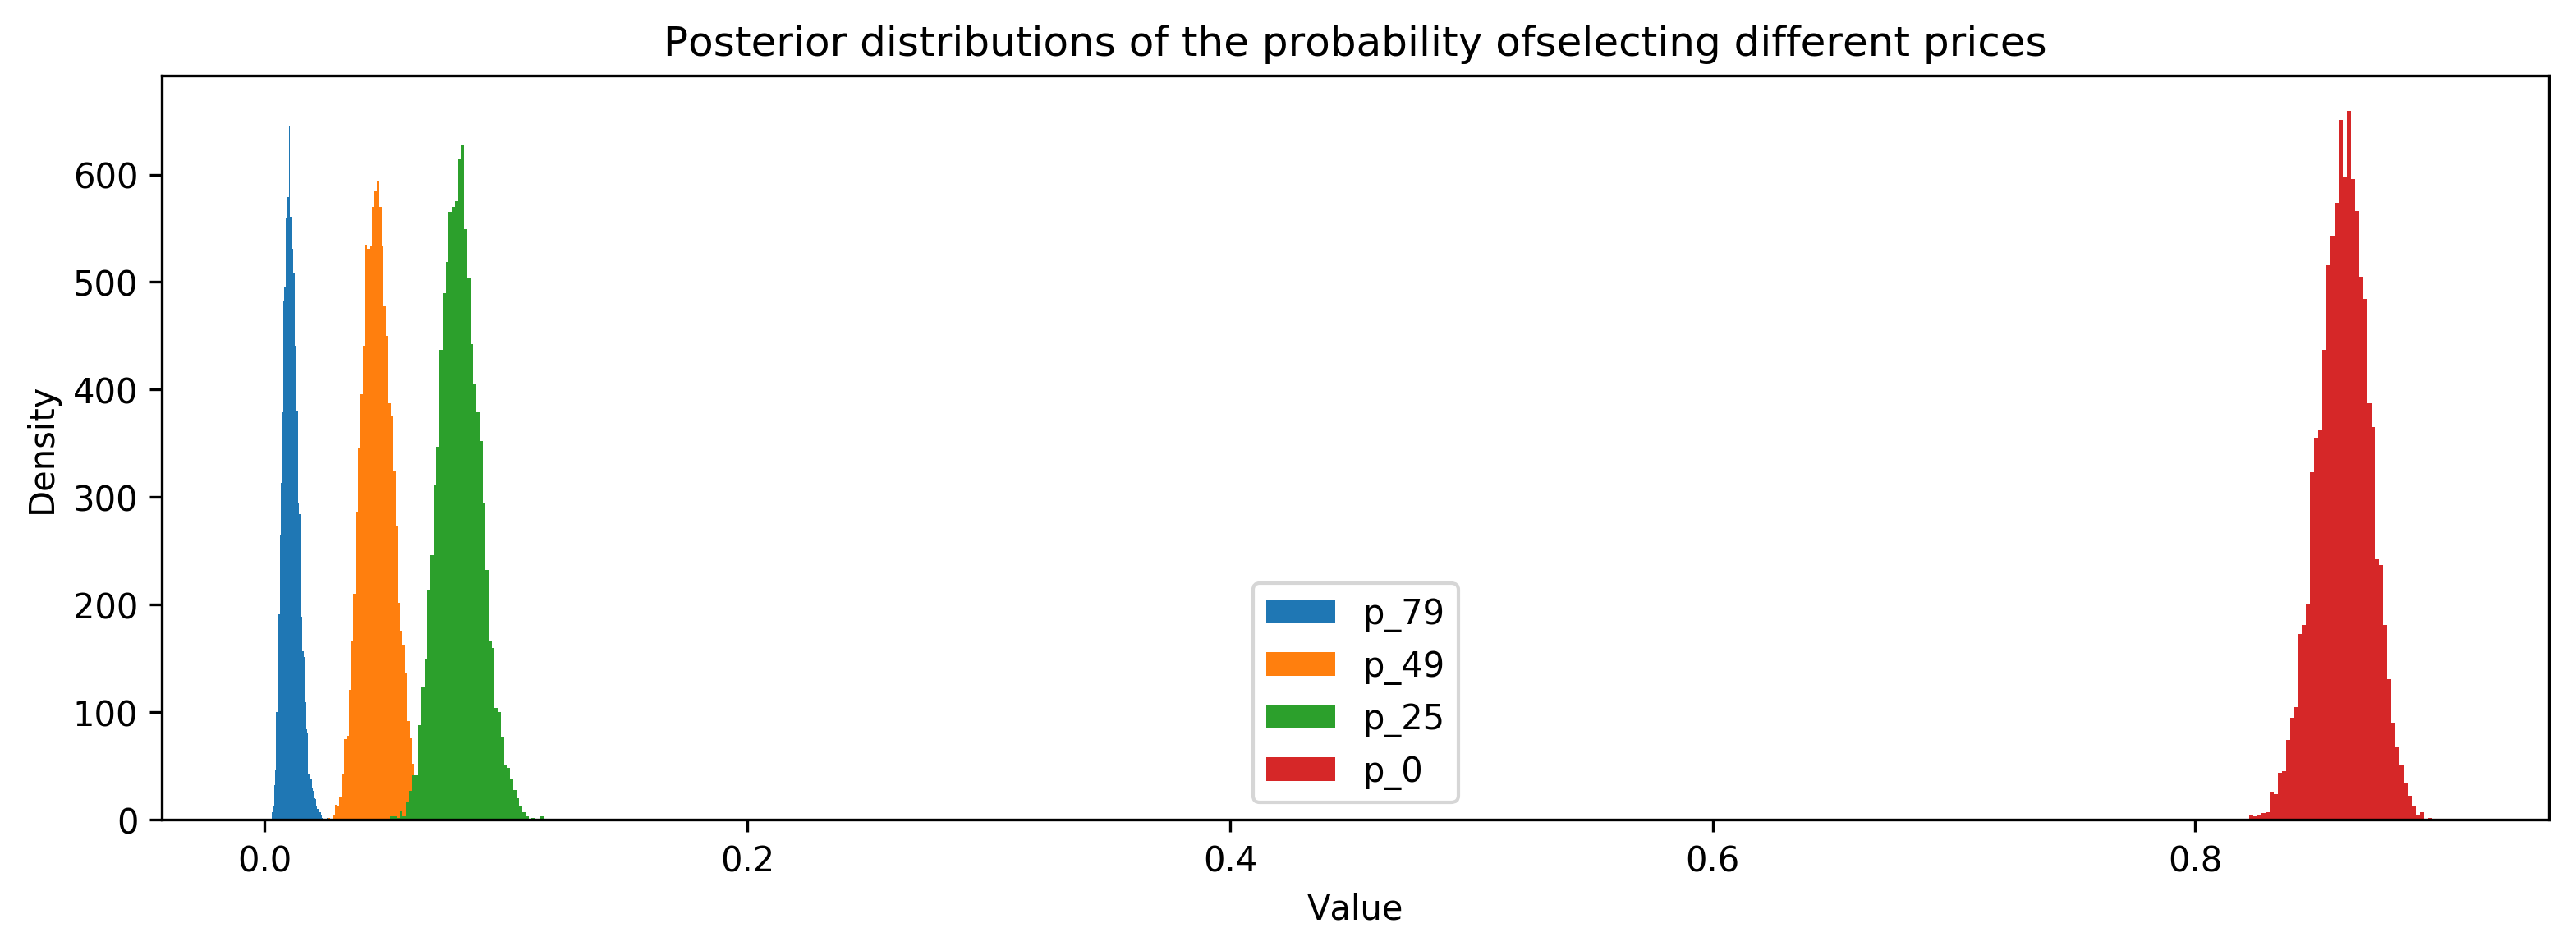

In [10]:
for i, label in enumerate(['p_79', 'p_49', 'p_25', 'p_0']):
    ax = plt.hist(posterior_samples[:, i], bins=50, 
                 label=label, histtype='stepfilled')
    
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the probability of\
 selecting different prices")
plt.legend()

## Expected Revenue
With our posterior, we can sample from the posterior and use that data to calculate the expected revenue. 

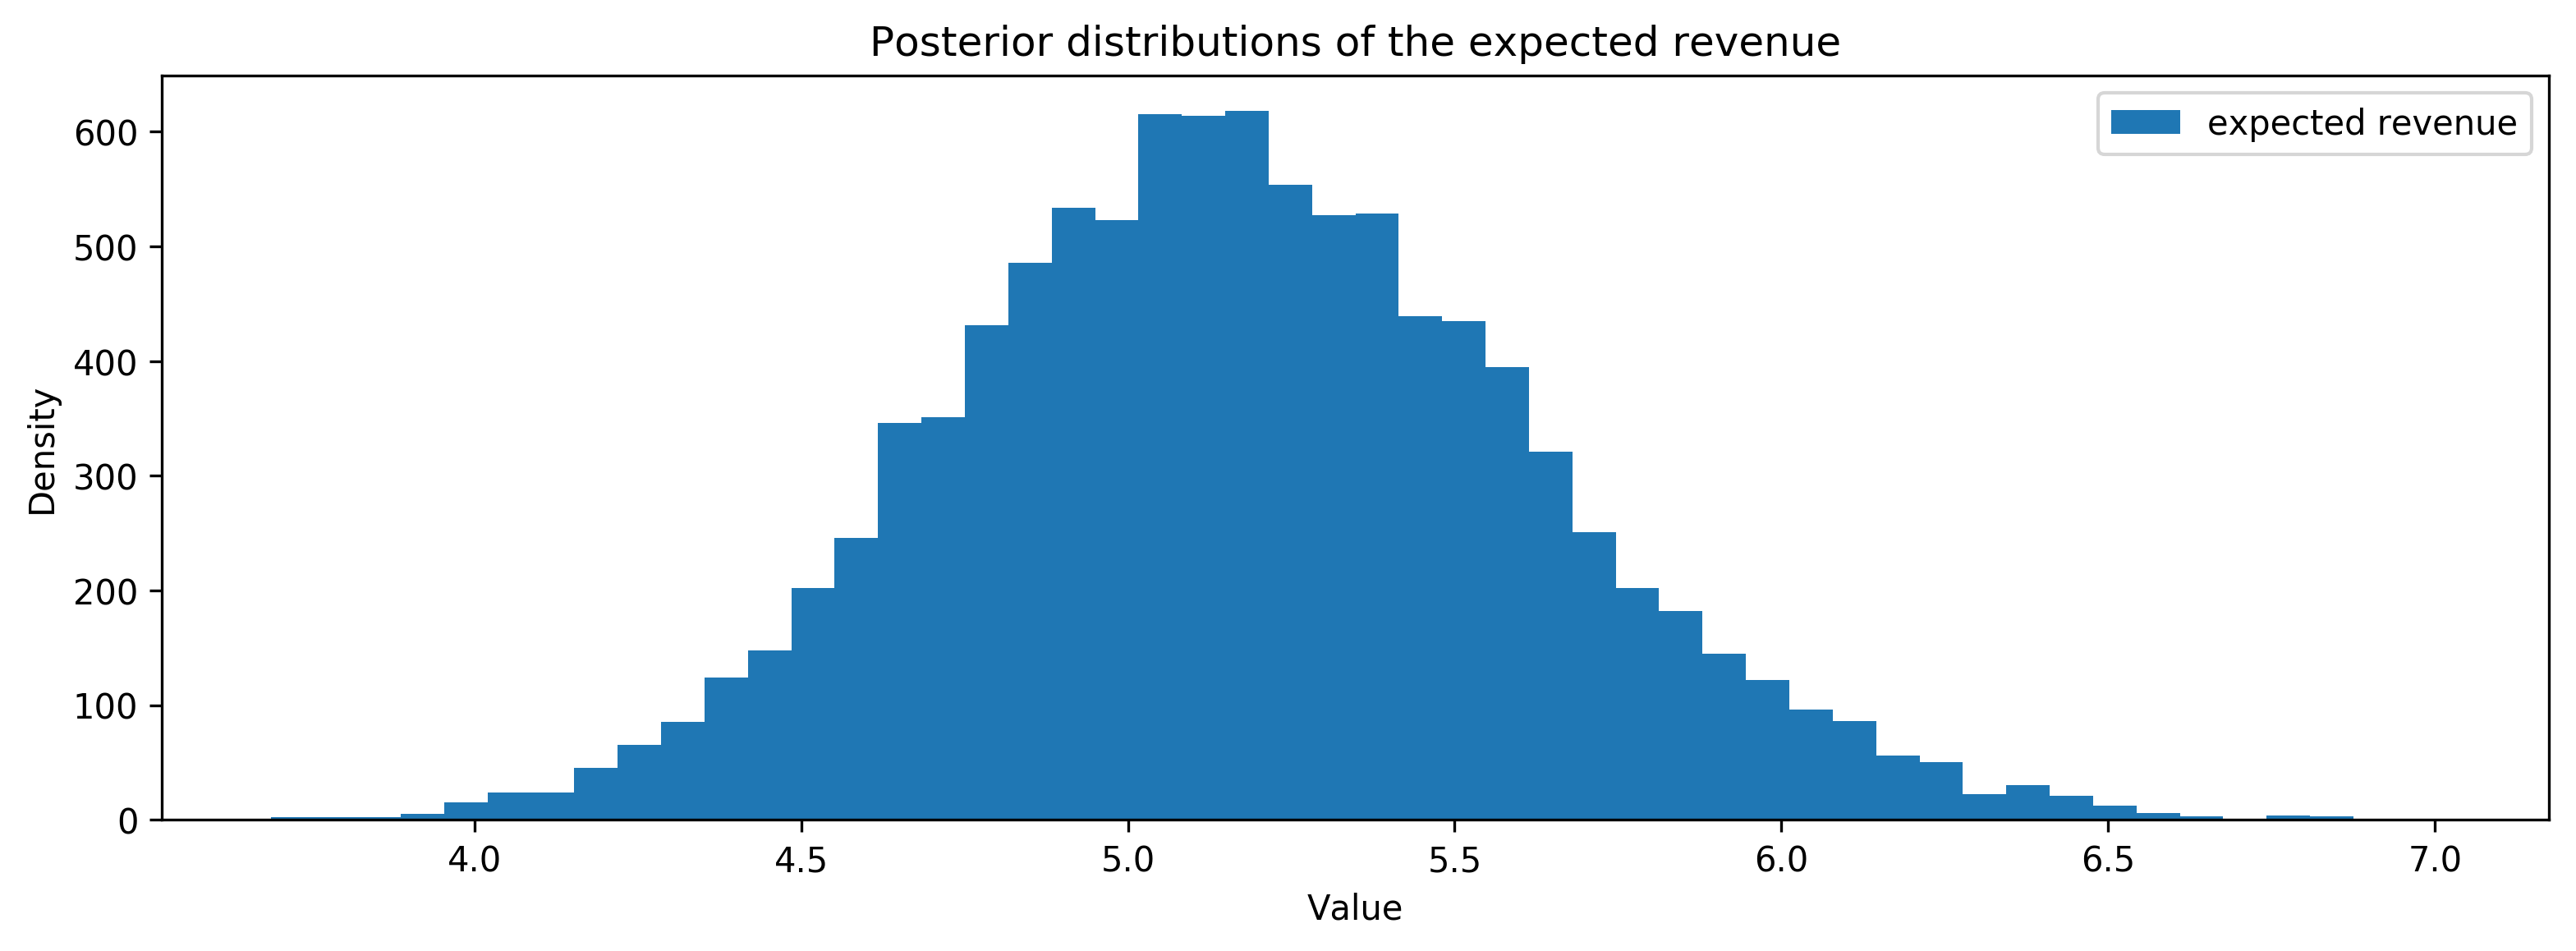

In [11]:
def expected_revenue(P):
    return 79*P[:,0] + 49*P[:, 1] + 25 * P[:,2] + 0*P[:, 3]

posterior_expected_revenue = expected_revenue(posterior_samples)
plt.hist(posterior_expected_revenue, histtype='stepfilled', label = 'expected revenue', bins=50)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the expected revenue")
plt.legend()

## Extending Expected Revenue to A/B Experiment

We can extend our problem to an A/B experiment by combining the two problems we have just solved. Suppose now we have two pages and for each page we have data on how many visitors purchase each package. Now the question is whether or not page A or page B is better at generating more revenue.

Again we use the dirichlet distribution as our posterior like above because we have two independent pages. 

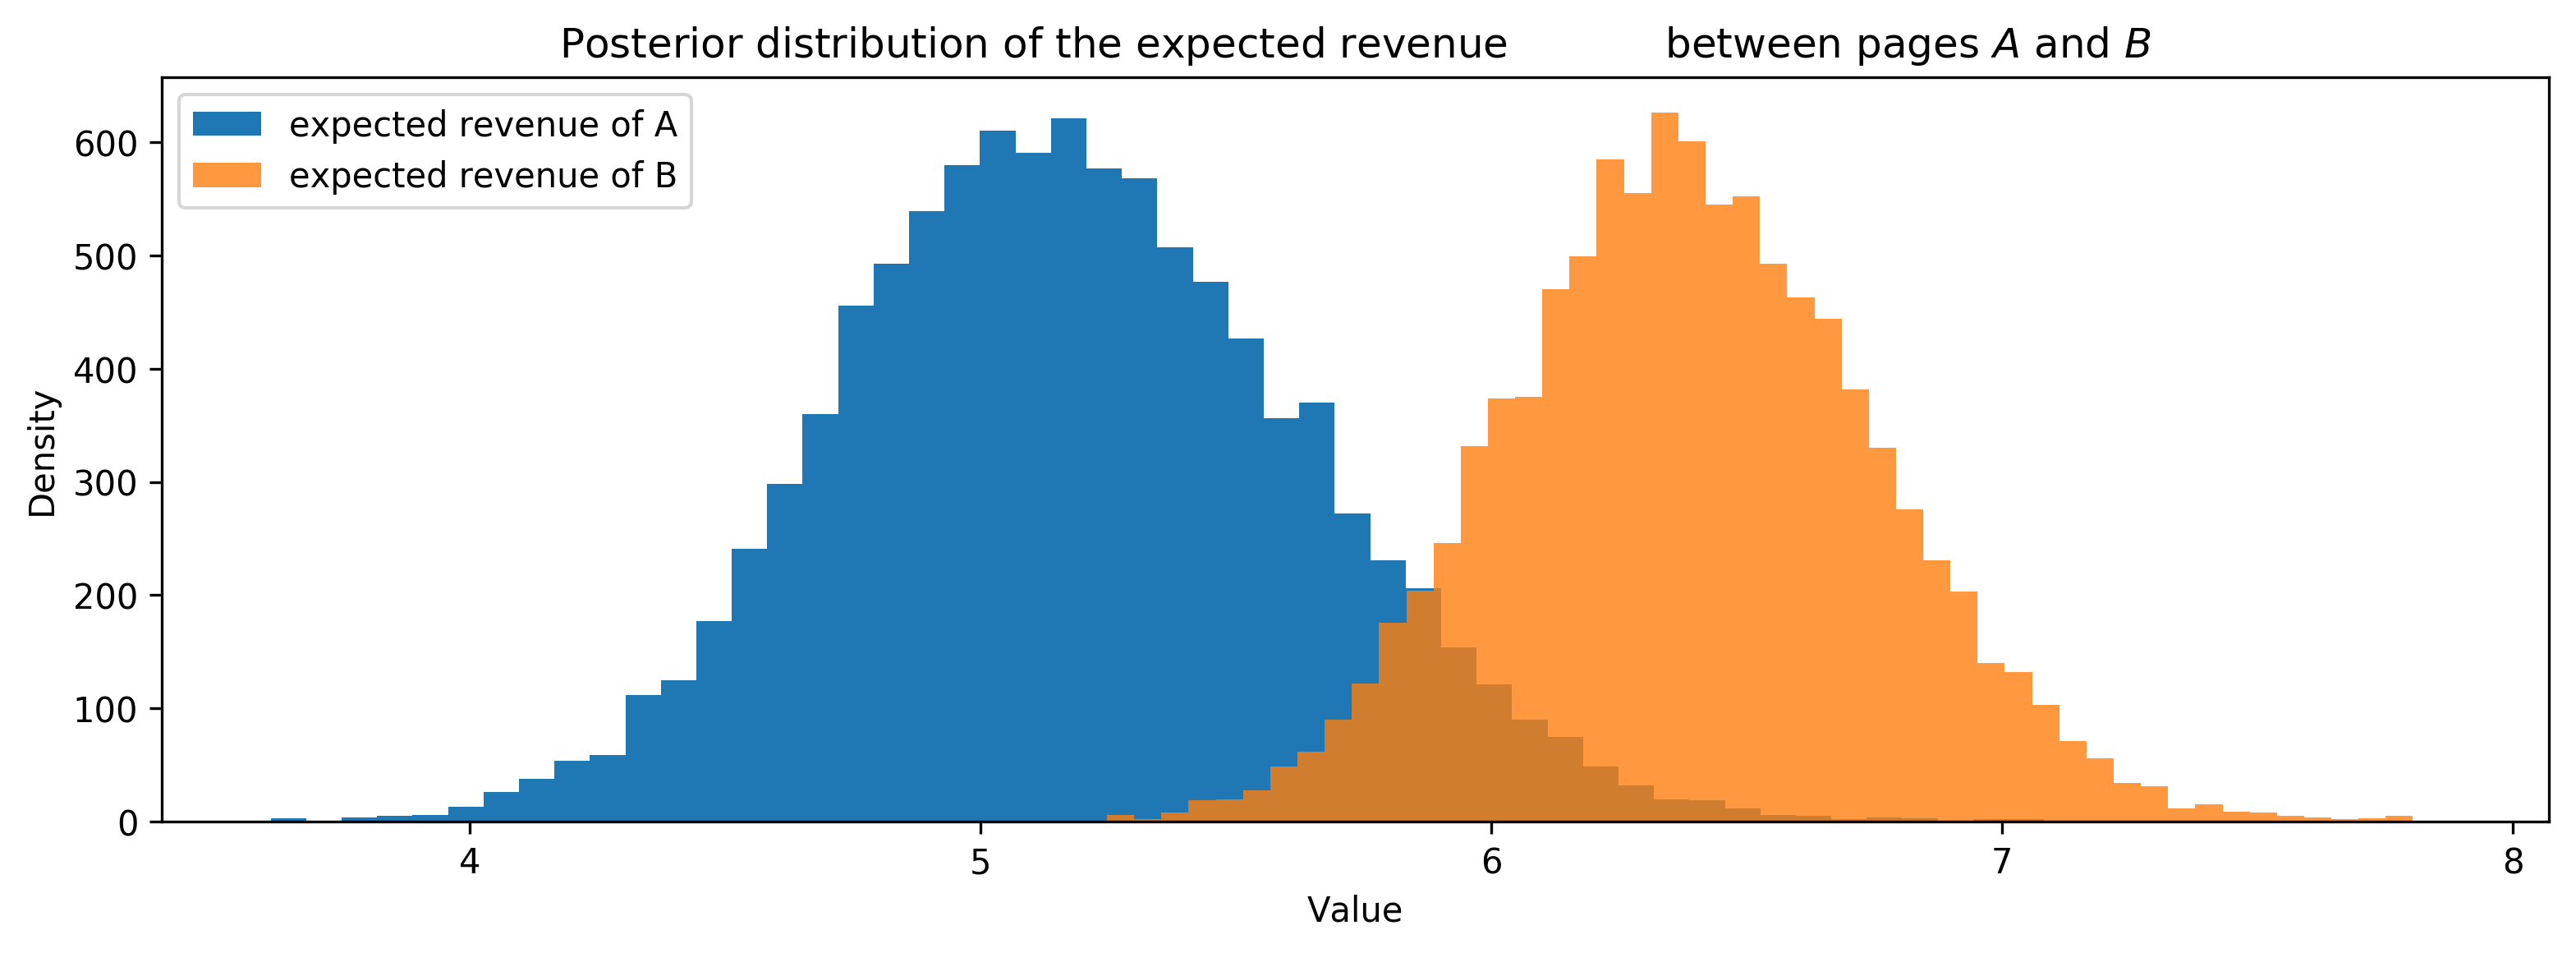

In [12]:
N_A = 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0 = N_A - (N_A_79 + N_A_49 + N_A_25)
observations_A = np.array([N_A_79, N_A_49, N_A_25, N_A_0])

N_B = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0 = N_B - (N_B_79 + N_B_49 + N_B_25)
observations_B = np.array([N_B_79, N_B_49, N_B_25, N_B_0])

prior_parameters = np.array([1, 1, 1, 1])
posterior_samples_A = dirichlet(prior_parameters + observations_A, 
                               size=10000)
posterior_samples_B = dirichlet(prior_parameters + observations_B, 
                               size=10000)
posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

plt.hist(posterior_expected_revenue_A, histtype='stepfilled', 
        label='expected revenue of A', bins=50)
plt.hist(posterior_expected_revenue_B, histtype='stepfilled', 
        label='expected revenue of B', bins=50, alpha=0.8) #alpha 0.8 makes B transparent

plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the expected revenue\
            between pages $A$ and $B$")
plt.legend();


In [13]:
p = (posterior_expected_revenue_B > posterior_expected_revenue_A).mean()
print('Probability that page B has higher revenue than page A: %.3f'%p)

Probability that page B has higher revenue than page A: 0.982


## Posterior Difference in Revenue Between Pages

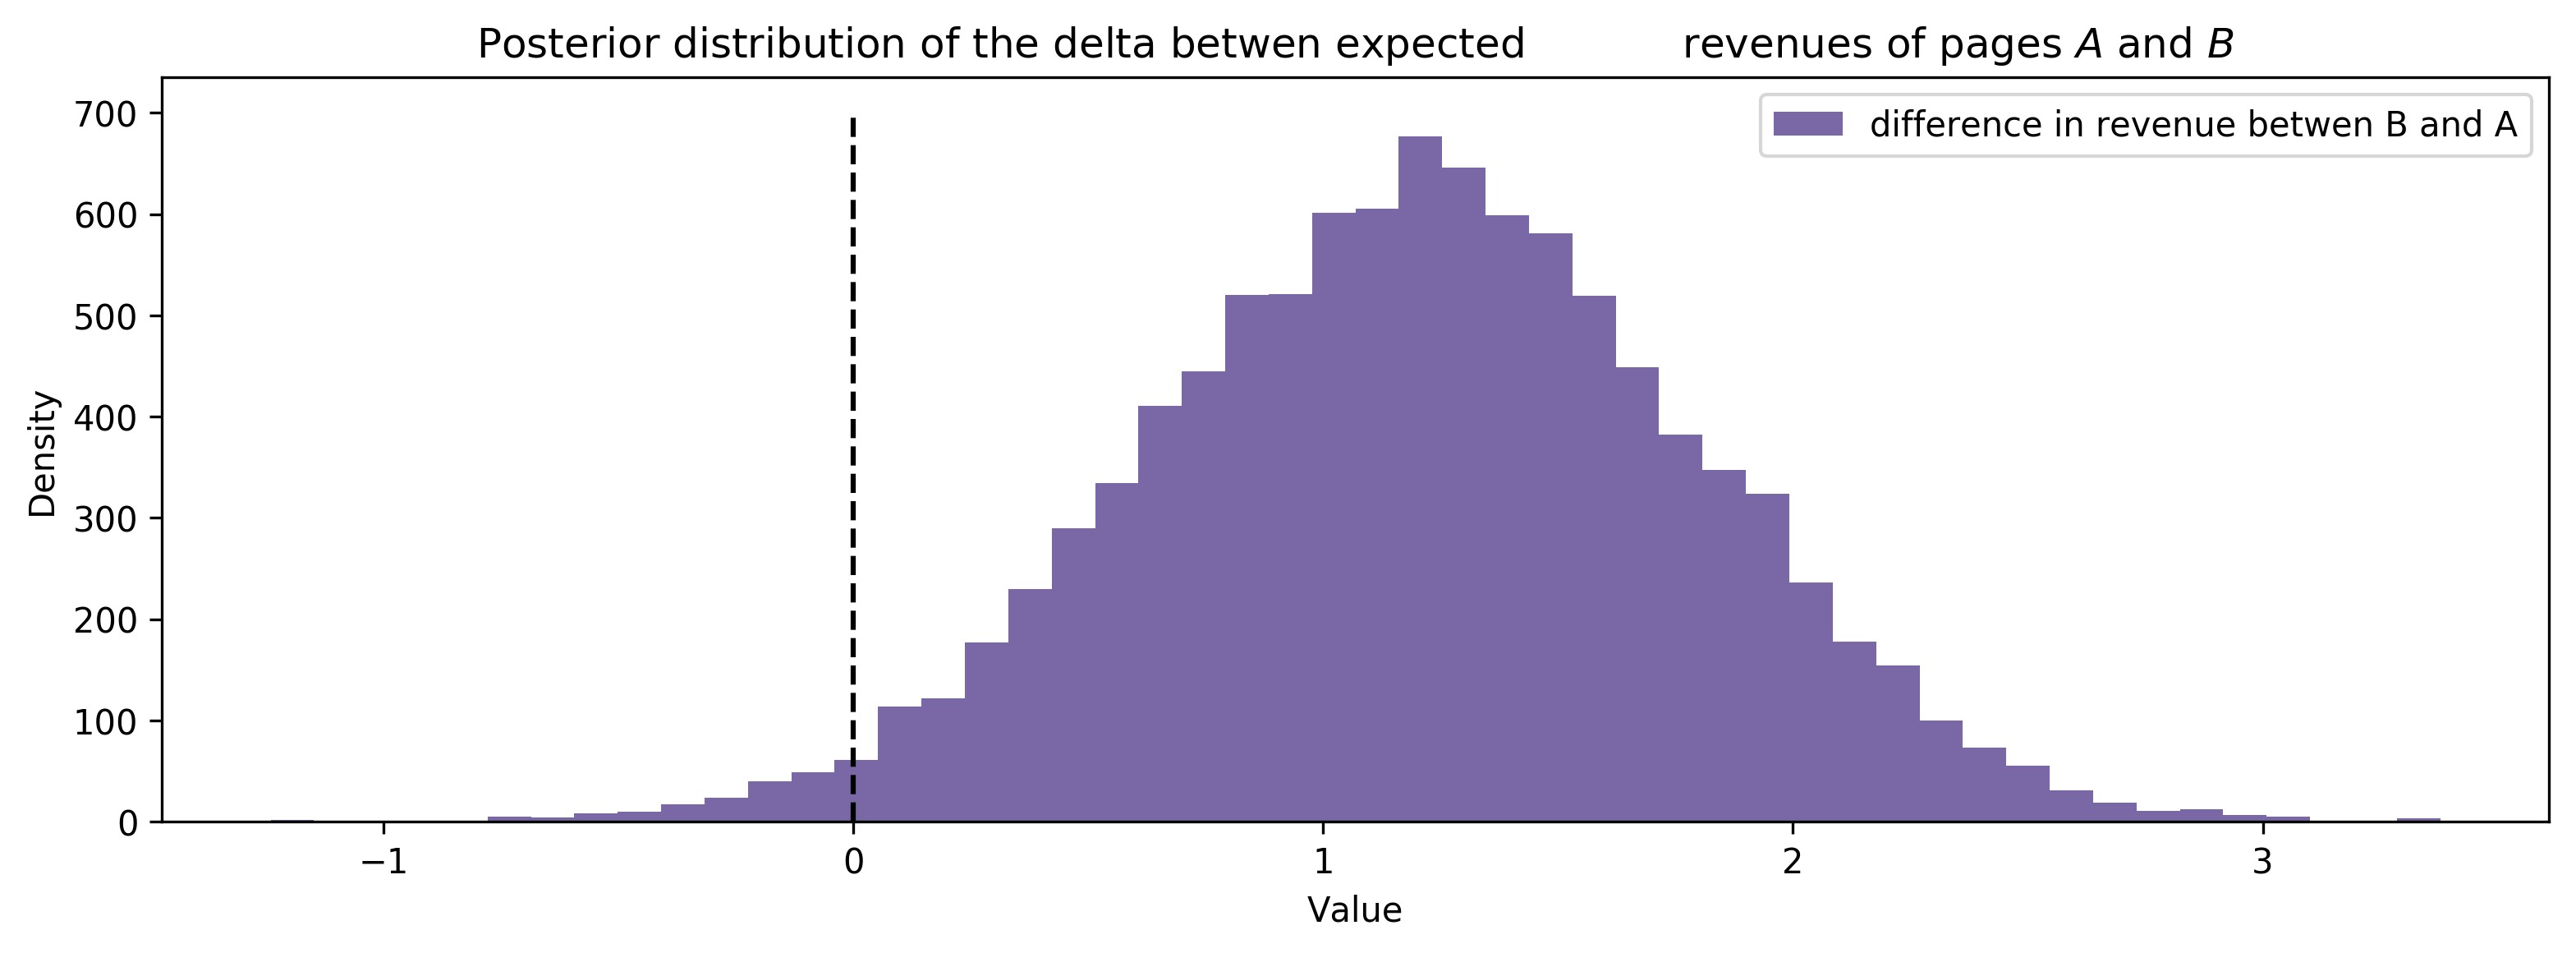

In [14]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A
plt.hist(posterior_diff, histtype='stepfilled', color='#7A68A6',
         label='difference in revenue betwen B and A', bins=50)
plt.vlines(0, 0, 700, linestyles='--')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior distribution of the delta betwen expected\
            revenues of pages $A$ and $B$')
plt.legend()

## T-test and continuous data: Suppose we have data about length of time user is on a test page

In [15]:
N = 250
mu_A, std_A = 30, 4
mu_B, std_B = 26, 7

#create durations users are on web page
durations_A = np.random.normal(mu_A, std_A, size=N)
durations_B = np.random.normal(mu_B, std_B, size=N)

print(durations_A[:8])
print(durations_B[:8])

[ 24.49080707  23.58436879  30.44328501  35.30365861  33.10693368
  30.7427801   27.74909487  27.09049888]
[ 25.73527575  22.95630749  17.15489379  30.83487583  20.66281478
  24.70100717  37.13056325  23.6929278 ]


In [16]:
import pymc as pm
import numpy as np

pooled_mean = np.r_[durations_A, durations_B].mean() #what is a pooled mean, pooled standard
pooled_std = np.r_[durations_A, durations_B].std()
tau = 1./np.sqrt(1000.*pooled_std)

mu_A = pm.Normal("mu_A", pooled_mean, tau)
mu_B = pm.Normal("mu_B", pooled_mean, tau)

std_A = pm.Uniform("std_A", pooled_std/1000., 1000.*pooled_std) 
std_B = pm.Uniform("std_B", pooled_std/1000., 1000.*pooled_std)

nu_minus_1 = pm.Exponential("nu-1", 1./29)

obs_A = pm.NoncentralT("obs_A", mu_A, 1.0/std_A**2, nu_minus_1 + 1, 
                       observed=True, value=durations_A)
obs_B = pm.NoncentralT("obs_B", mu_B, 1.0/std_B**2, nu_minus_1 + 1, 
                       observed=True, value=durations_B)

mcmc = pm.MCMC([obs_A, obs_B, mu_A, mu_B, std_A, std_B, nu_minus_1])
mcmc.sample(25000, 10000)




 [-----------------100%-----------------] 25000 of 25000 complete in 18.0 sec

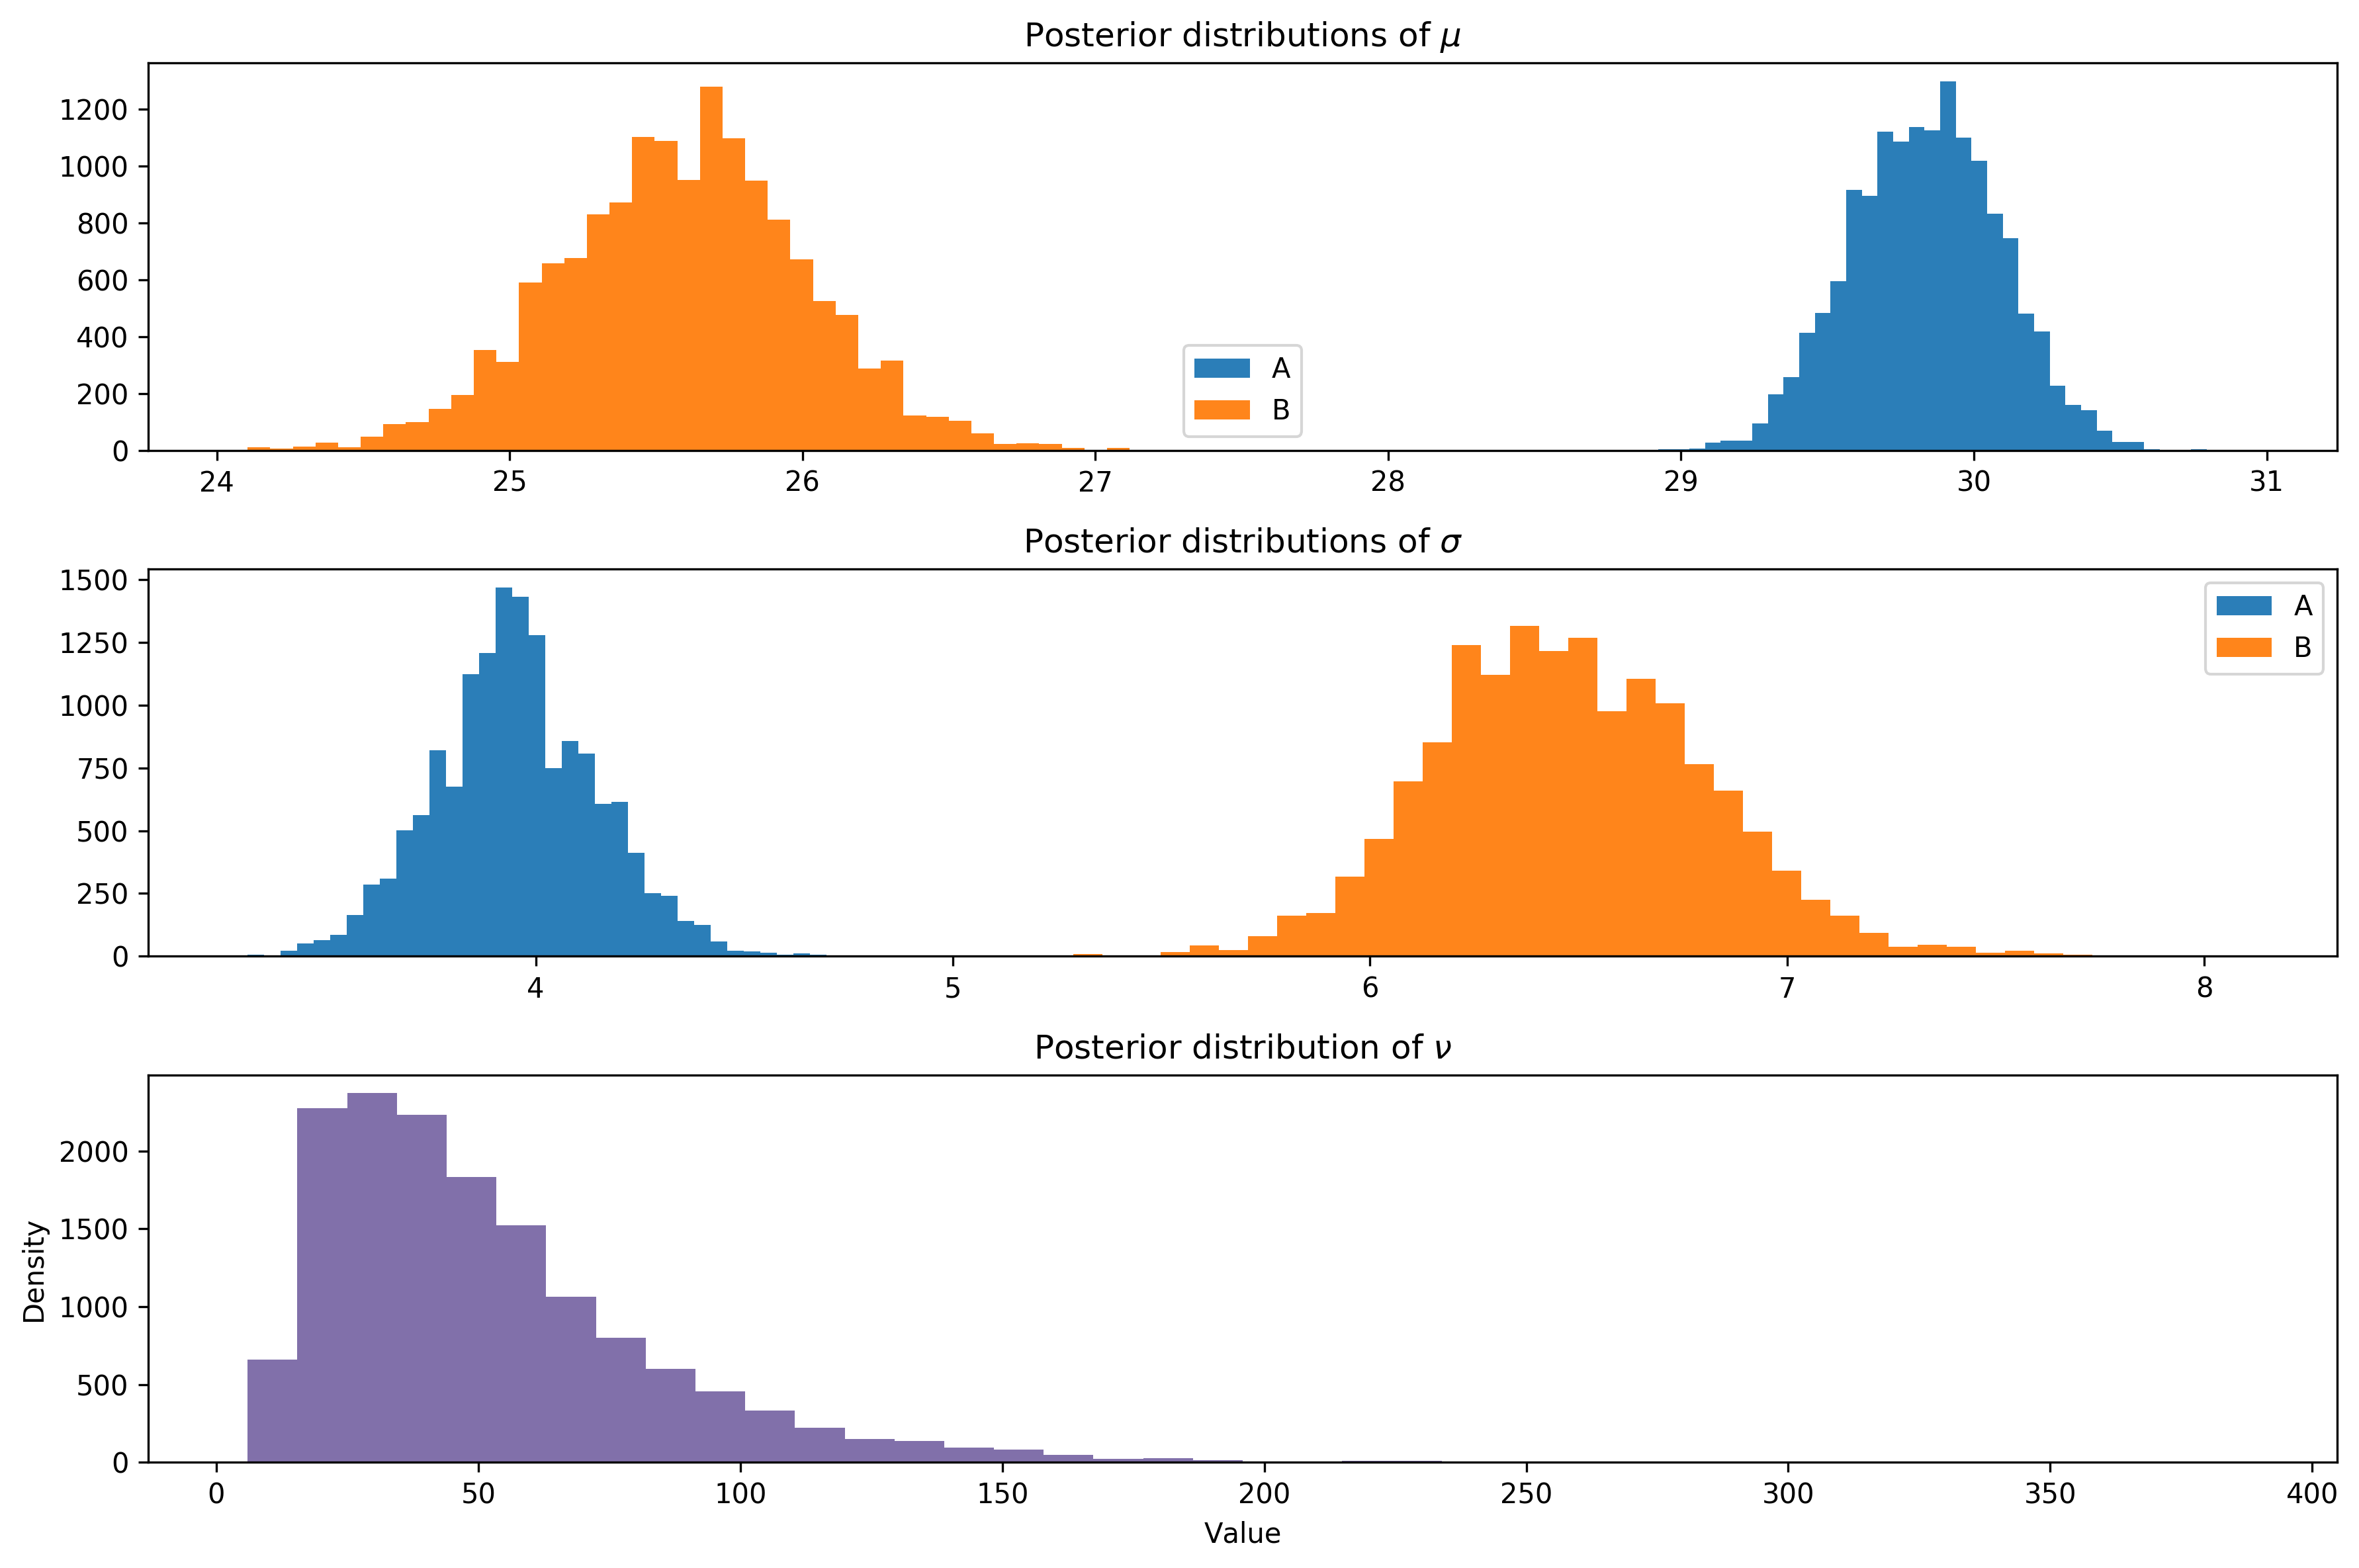

In [17]:
mu_A_trace, mu_B_trace = mcmc.trace('mu_A')[:], mcmc.trace('mu_B')[:]
std_A_trace, std_B_trace = mcmc.trace('std_A')[:], mcmc.trace('std_B')[:]
nu_trace = mcmc.trace("nu-1")[:] + 1

figsize(12, 8)
def _hist(data, label, **kwargs):
    return plt.hist(data, bins=40, histtype='stepfilled', 
                    alpha=0.95, label=label, **kwargs)

ax = plt.subplot(3, 1, 1)
_hist(mu_A_trace, 'A')
_hist(mu_B_trace, 'B')
plt.legend()
plt.title('Posterior distributions of $\mu$')

ax = plt.subplot(3, 1, 2)
_hist(std_A_trace, 'A')
_hist(std_B_trace, 'B')
plt.legend()
plt.title('Posterior distributions of $\sigma$')

ax = plt.subplot(3, 1, 3)
_hist(nu_trace, '', color='#7A68A6')
plt.title(r'Posterior distribution of $\nu$')
plt.xlabel('Value')
plt.ylabel('Density')
plt.tight_layout();

## Estimating the Increase

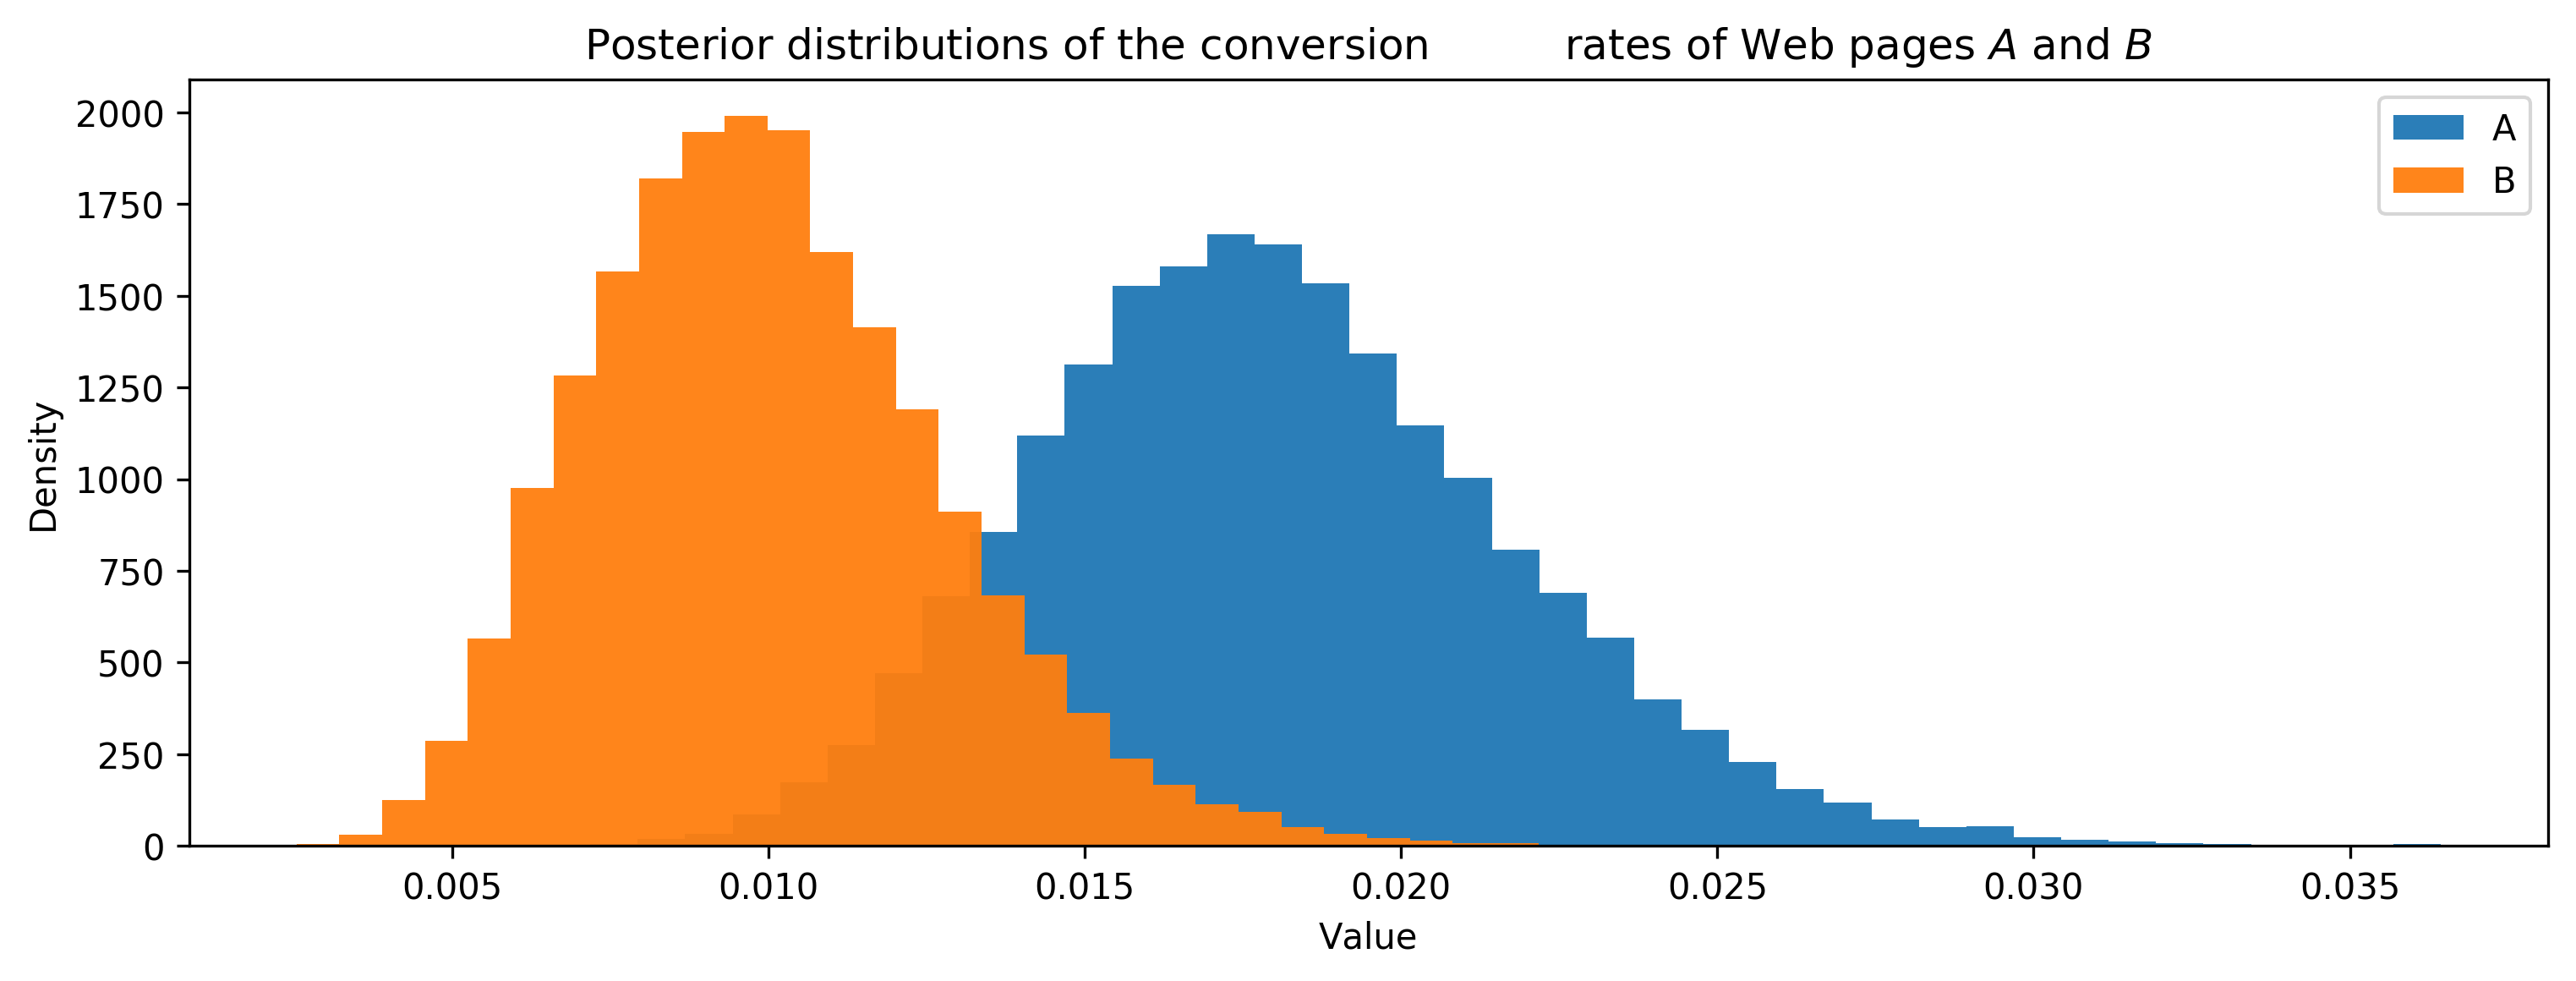

In [18]:
figsize(12, 4)

visitors_to_A = 1275
visitors_to_B = 1300

conversions_from_A = 22
conversions_from_B = 12

alpha_prior = 1
beta_prior = 1

posterior_A = beta(alpha_prior + conversions_from_A, 
                   beta_prior + visitors_to_A - conversions_from_A)

posterior_B = beta(alpha_prior + conversions_from_B,
                   beta_prior + visitors_to_B - conversions_from_B)

samples = 20000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

_hist(samples_posterior_A, 'A')
_hist(samples_posterior_B, 'B')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the conversion\
          rates of Web pages $A$ and $B$")
plt.legend()

(array([  4.30000000e+01,   3.30000000e+02,   1.16900000e+03,
          2.14700000e+03,   2.72900000e+03,   2.84900000e+03,
          2.57700000e+03,   2.13500000e+03,   1.65300000e+03,
          1.26600000e+03,   9.71000000e+02,   6.32000000e+02,
          4.58000000e+02,   3.41000000e+02,   1.95000000e+02,
          1.72000000e+02,   1.03000000e+02,   7.40000000e+01,
          4.70000000e+01,   2.90000000e+01,   2.70000000e+01,
          9.00000000e+00,   1.20000000e+01,   5.00000000e+00,
          5.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([-0.52607117, -0.31066362, -0.09525607,  0.12015148,  0.33555903,
         0.55096658,  0.76637412,  0.98178167,  1.19718922,  1.41259677,
         1.62800432,

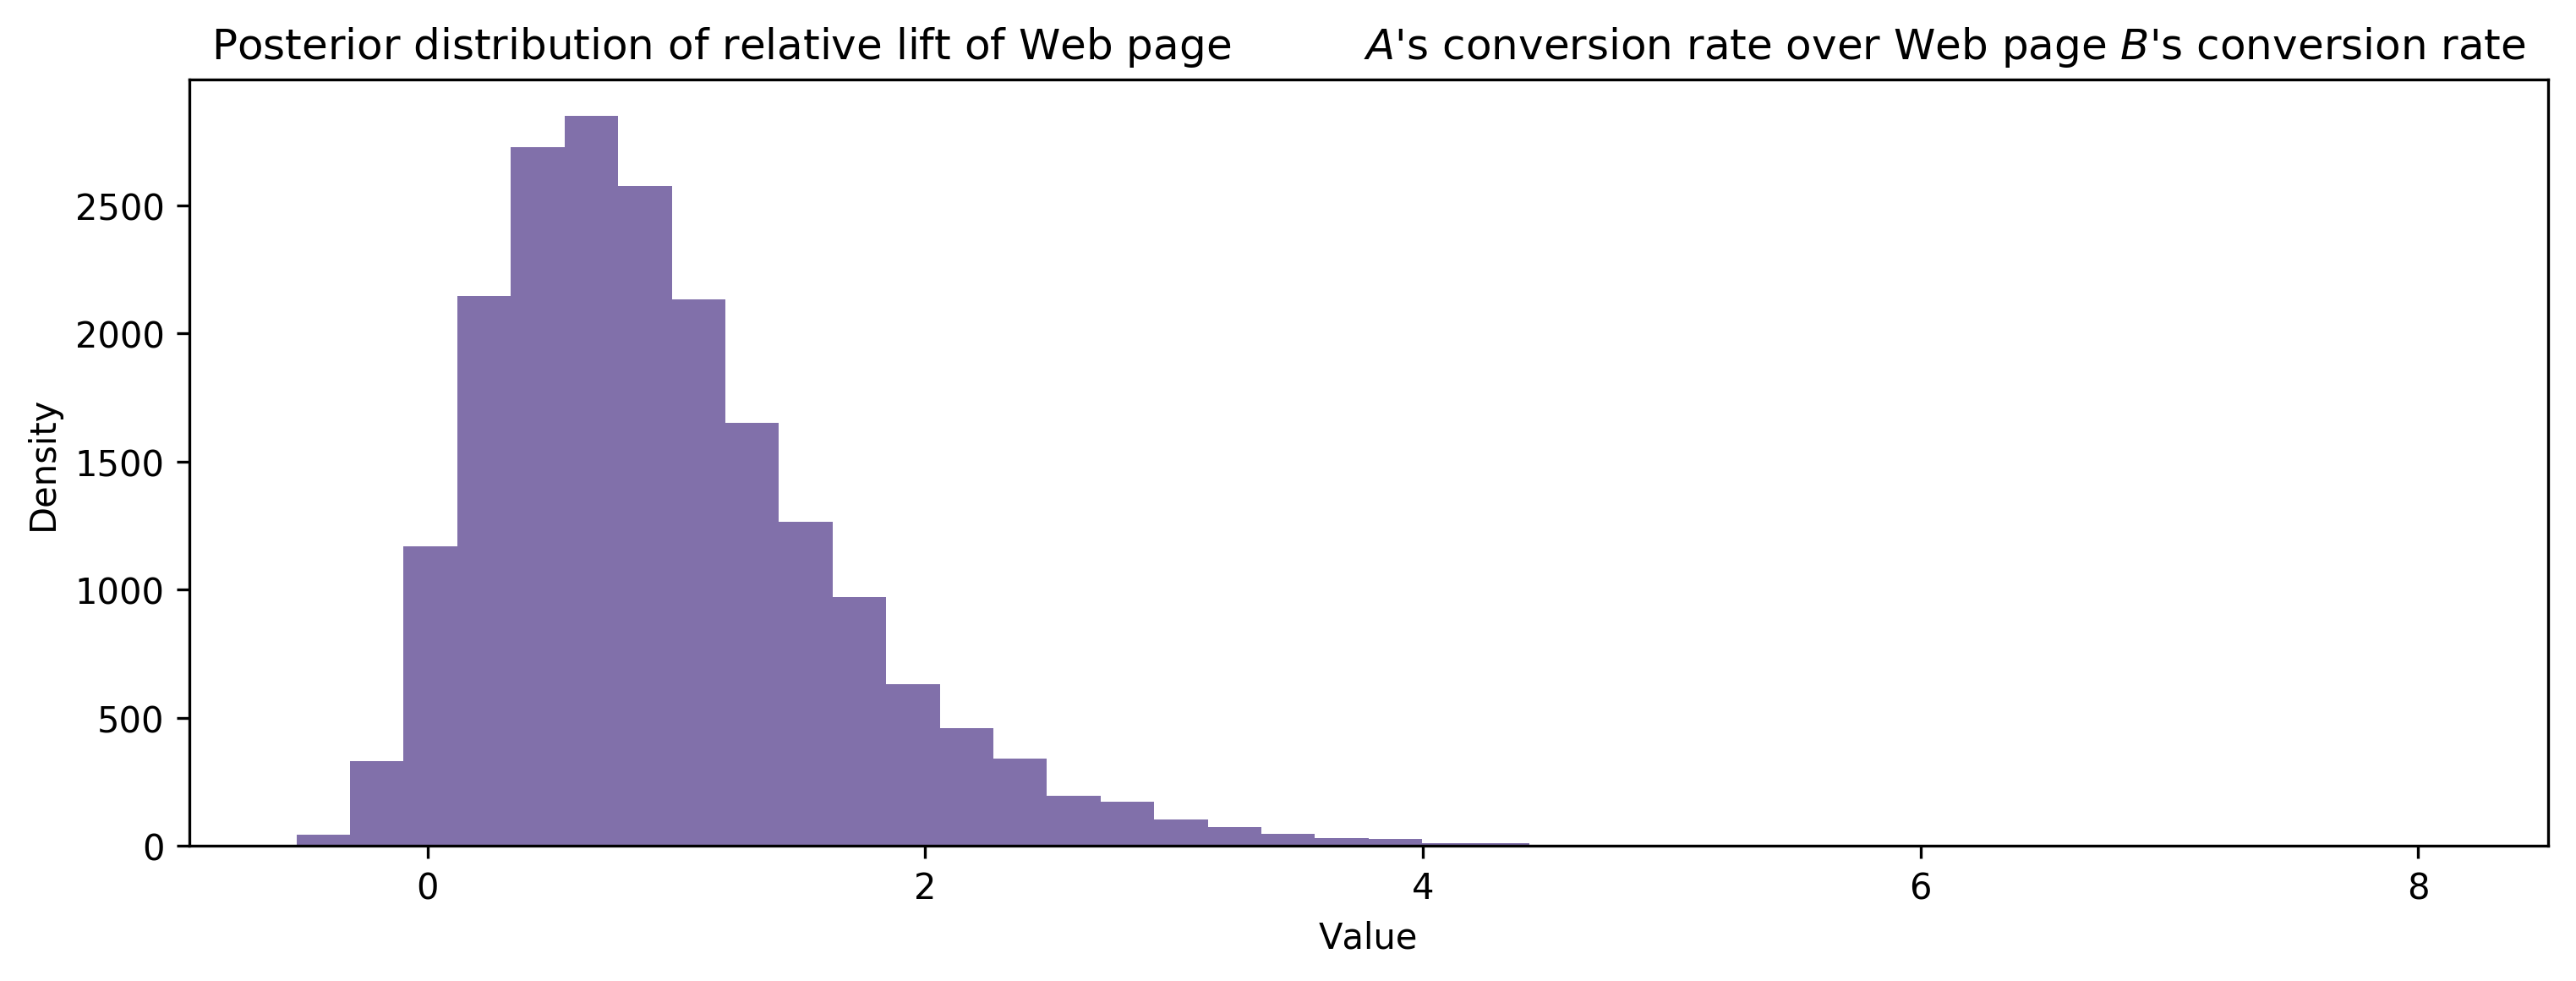

In [19]:
def relative_increase(a, b):
    return (a-b)/b

posterior_rel_increase = relative_increase(samples_posterior_A, samples_posterior_B)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of relative lift of Web page\
          $A$'s conversion rate over Web page $B$'s conversion rate")

_hist(posterior_rel_increase, 'relative increase', color='#7A68A6')

In [20]:
print((posterior_rel_increase > 0.2).mean())
print((posterior_rel_increase > 0.5).mean())

0.88835
0.71225


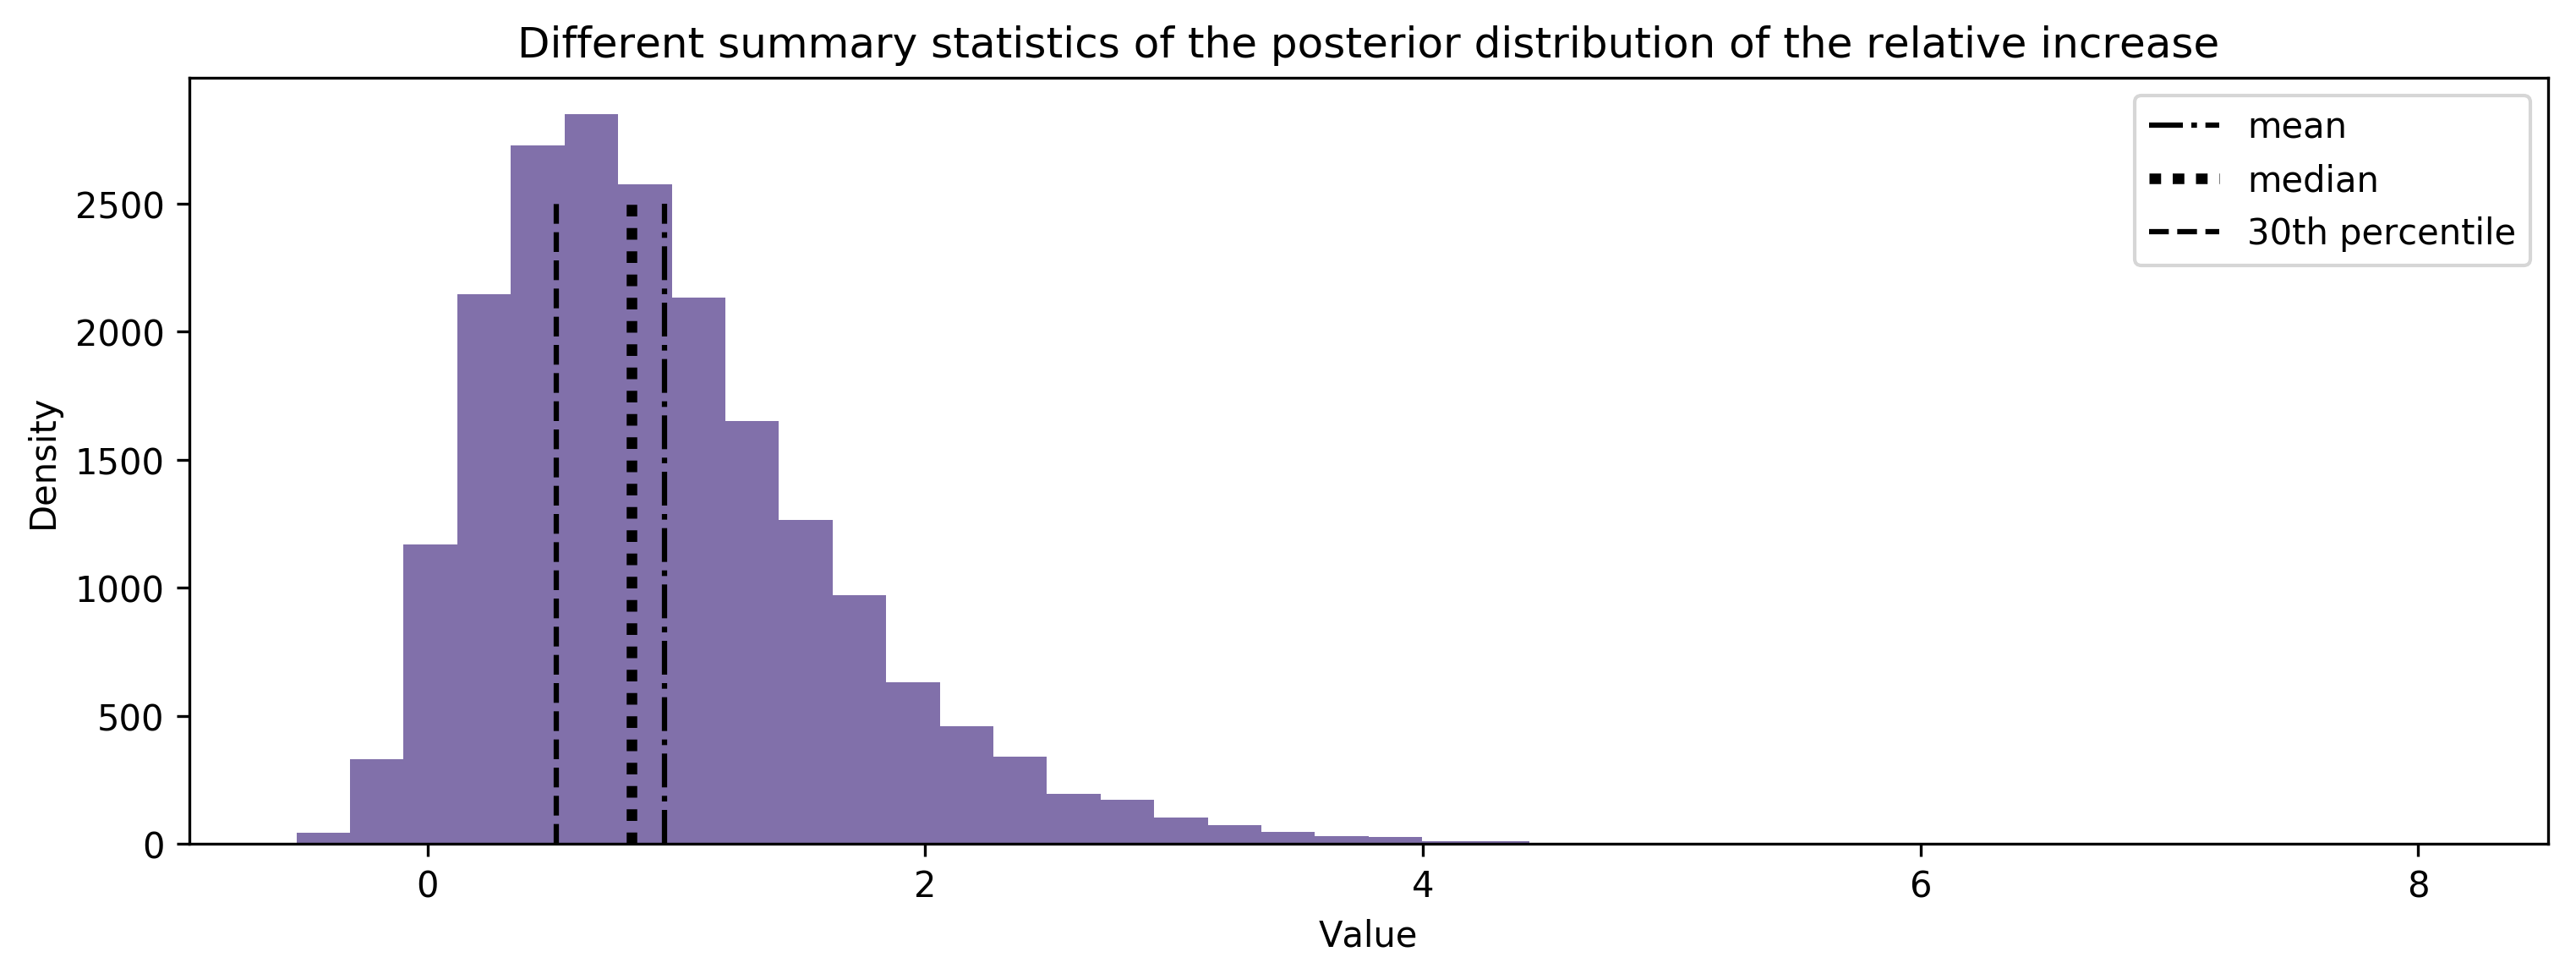

In [21]:
mean = posterior_rel_increase.mean()
median = np.percentile(posterior_rel_increase, 50)
conservative_percentile = np.percentile(posterior_rel_increase, 30)

_hist(posterior_rel_increase,'', color='#7A68A6')
plt.vlines(mean, 0, 2500, linestyles='-.', label='mean')
plt.vlines(median, 0, 2500, linestyles=':', label='median', lw=3)
plt.vlines(conservative_percentile, 0, 2500, linestyles='--',
           label='30th percentile')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Different summary statistics of the posterior distribution of the relative increase")
plt.legend()

In [22]:
print('mean: ', mean)
print('median: ', median)
print('30th percentile: ', conservative_percentile)

mean:  0.95207517454
median:  0.822061289989
30th percentile:  0.518281106891
